## 9.10 ARIMA vs ETS
It is a commonly held myth that ARIMA models are more general than exponential smoothing. While linear exponential smoothing models are all special cases of ARIMA models, the non-linear exponential smoothing models have no equivalent ARIMA counterparts. On the other hand, there are also many ARIMA models that have no exponential smoothing counterparts. In particular, all ETS models are non-stationary, while some ARIMA models are stationary. The figure below shows the overlap between the two model classes.

![arima_ets](../figures/venn_arima_ets.png)

The ETS models with seasonality or non-damped trend or both have two unit roots (i.e., they need two levels of differencing to make them stationary). All other ETS models have one unit root (they need one level of differencing to make them stationary).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from utils import *

In [3]:
from get_data import global_economy

In [5]:
aus_econ = (
    global_economy.query("Code == 'AUS'")
    .assign(
        date=lambda df: pd.to_datetime(df["Year"], format="%Y"),
        Population=lambda df: df.Population / 1.0e6,
    )
    .set_index("date")
    .pipe(set_freq)
)
aus_econ["idx"] = np.arange(len(aus_econ))

### AutoETS model from `statsforecast`
The `statsforecast` library has an AutoETS Model (generalised exponential smoothing) just like AutoARIMA, which automatically selects the best model to fit the data. We can try it on the Australian economy dataset.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [134]:
df = aus_econ['Population'].reset_index()
df['unique_id'] = 1
df.columns=['ds', 'y', 'unique_id']

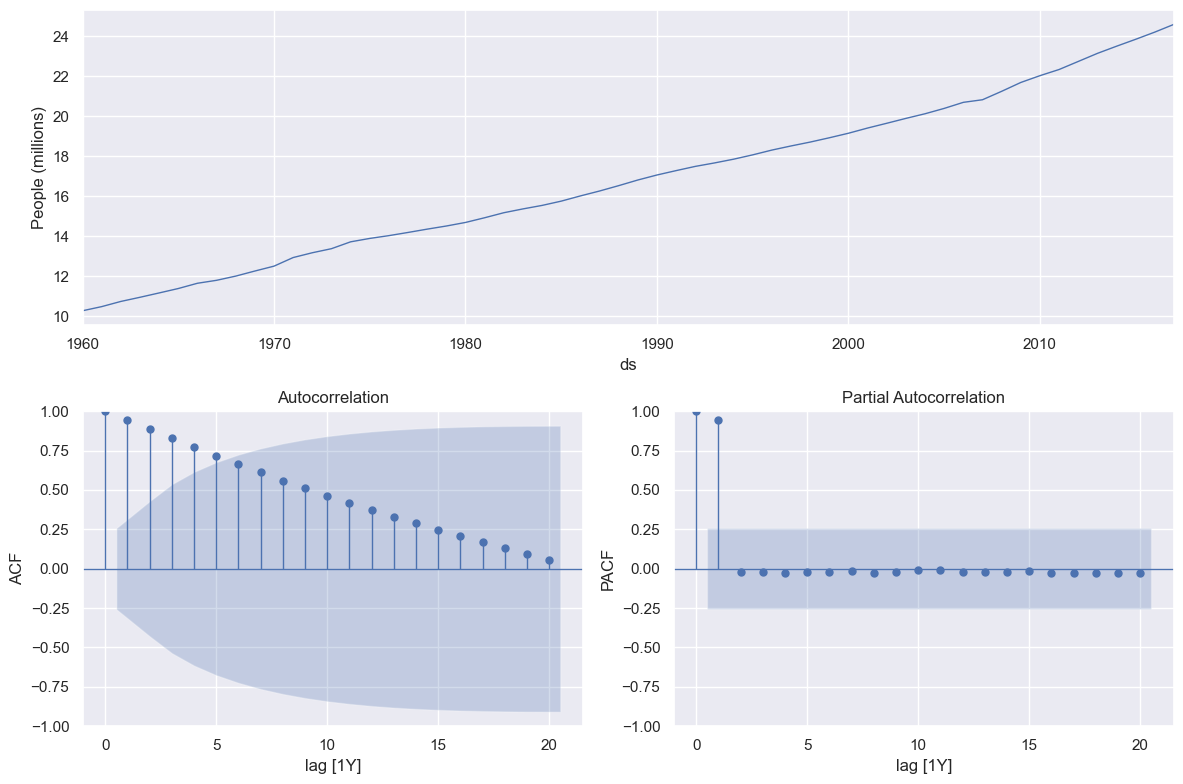

In [138]:
plot_autocorrelations(df.set_index('ds').y, lags=20, ylabel='People (millions)', freq='Y')

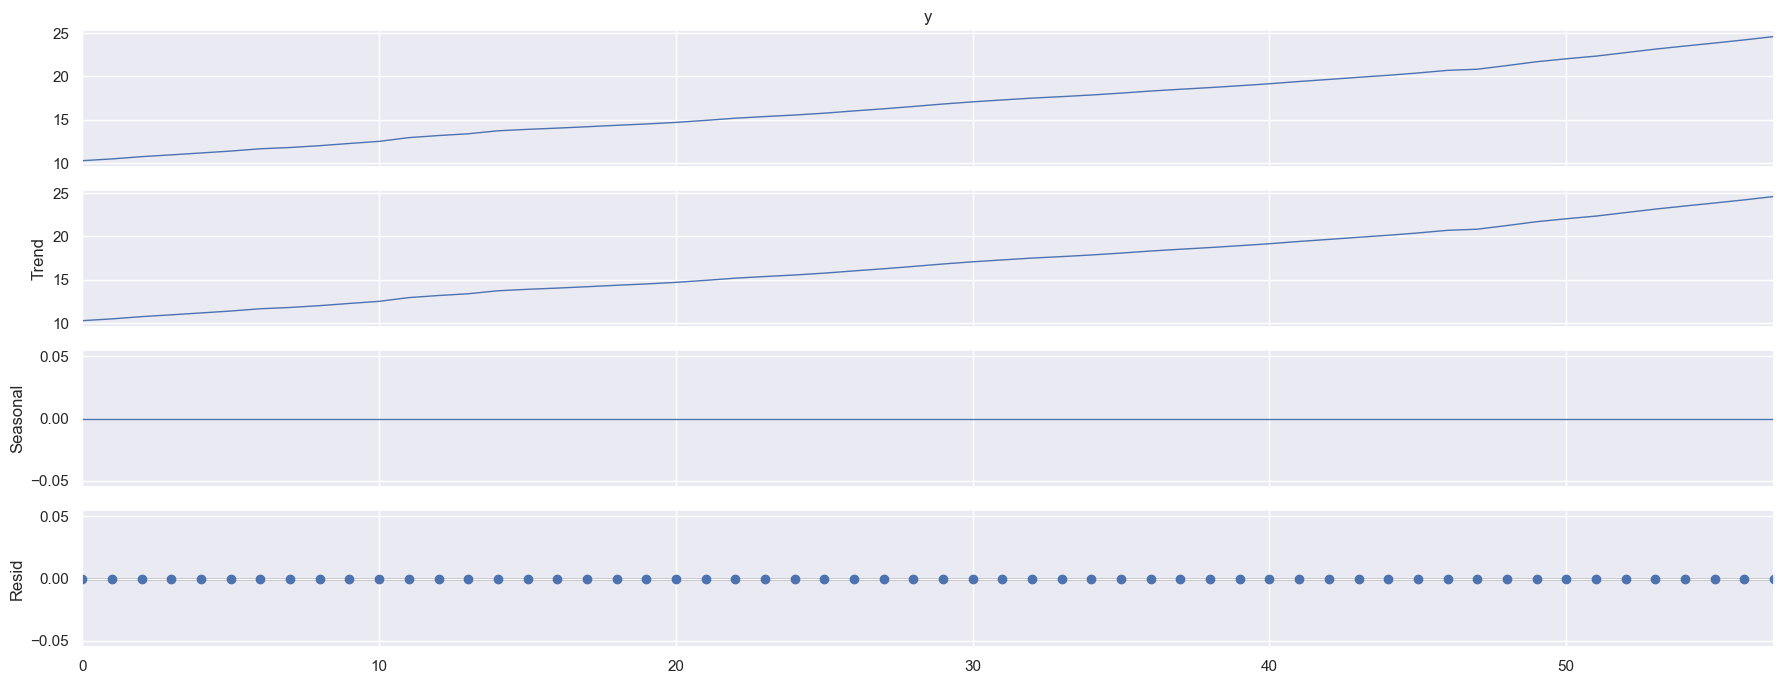

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df['y'], model='add', period=1)
a.plot();

The above figure suggests that there is a trend but no seasonality, so we can select models appropriately. 

Now split data into training and test set.

In [24]:
train_df = df[df.ds < '2012-01-01']
test_df = df[df.ds >= '2012-01-01']

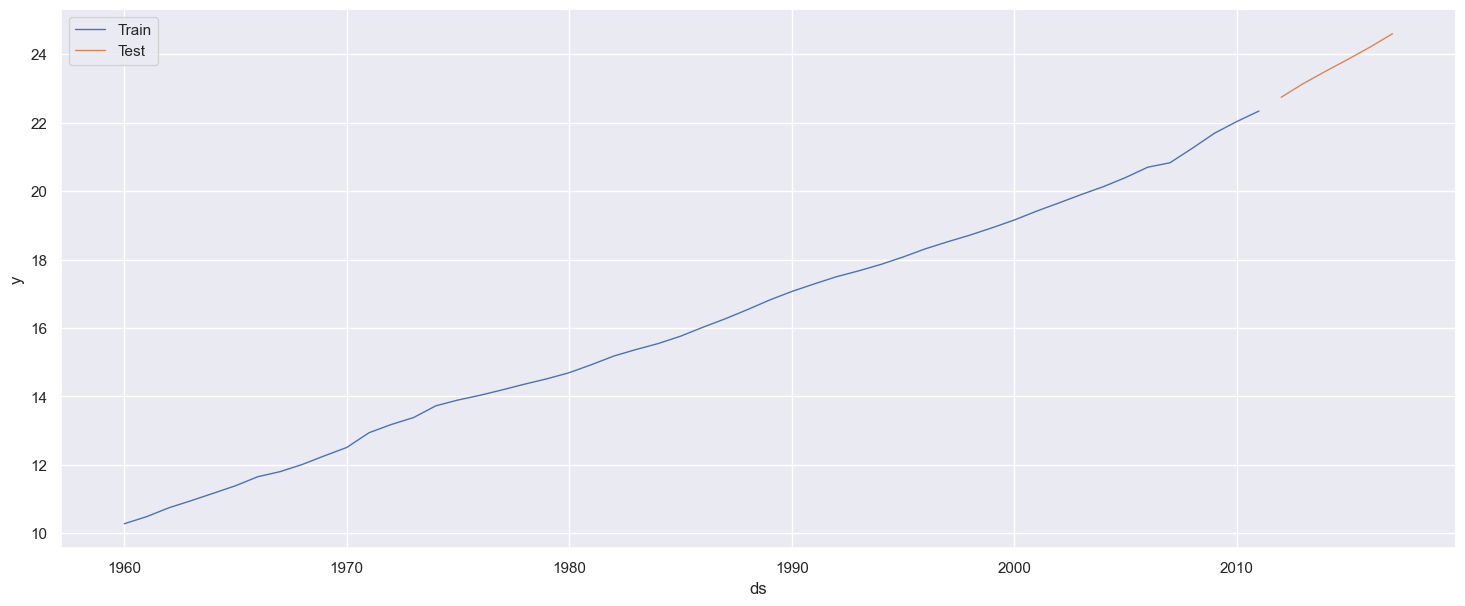

In [27]:
sns.lineplot(train_df, x='ds', y='y', label='Train')
sns.lineplot(test_df, x='ds', y='y', label='Test')
plt.show()

#### Implementation of AutoETS with StatsForecast
Automatically selects the best `ETS(Error, Trend, Seasonality)` model using an information criterion. The default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood. The state-space equations can be determined based on their $M$ multiplicative, $A$ additive, $Z$ optimised or $N$ ommitted components. The model string parameter defines the ETS equations: $E$ in $[M, A, Z]$, $T$ in $[N, A, M, Z]$, and $S$ in $[N, A, M, Z]$.

For example when `model='ANN` (additive error, no trend and no seasonality), `ETS` will explore only a simple exponential smoothing. 

If the component is selected as `Z`, it operates as a placeholder to as the `AutoETS` model to figure out the best parameter.

In [28]:
from statsforecast.models import AutoETS

In [116]:
autoets = AutoETS(model=['Z', "Z", 'N'], alias='AutoETS', season_length=1)

In [117]:
autoets = autoets.fit(train_df['y'].values)
autoets

AutoETS

##### Model prediction

In [123]:
y_hat_dict = autoets.predict(h=6)
y_hat_dict

{'mean': array([22.57109956, 22.80218284, 23.03326613, 23.26434941, 23.49543269,
        23.72651597])}

In [124]:
forecast=pd.Series(pd.date_range("2012-01-01", freq="ys", periods=6))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast["hat"]=y_hat_dict.get("mean")
forecast["unique_id"]="1"

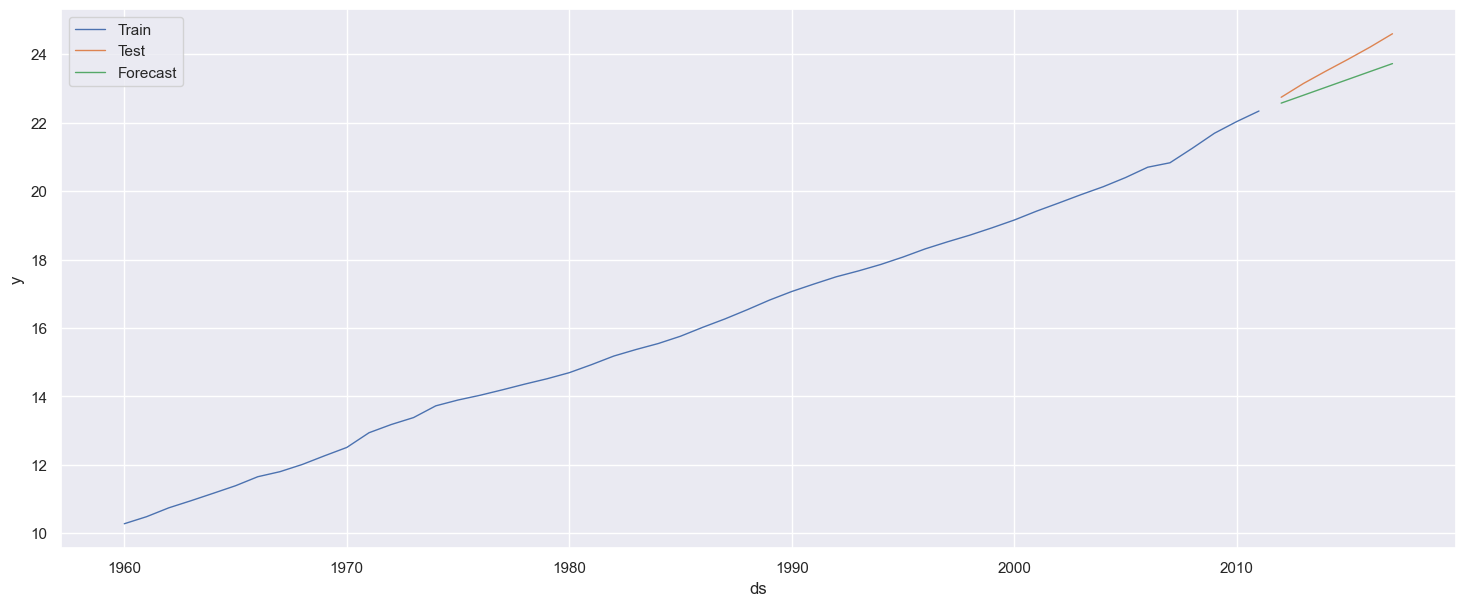

In [125]:
sns.lineplot(train_df,x="ds", y="y", label="Train")
sns.lineplot(test_df, x="ds", y="y", label="Test")
sns.lineplot(forecast,x="ds", y="hat", label="Forecast",)
plt.show()

In [120]:
y_hat_dict = autoets.predict(h=6, level=[80, 90, 95])

In [127]:
def plot_actual_and_forecast(model, df, ds_start, freq, prediction_horizon):
    forecast=pd.Series(pd.date_range(ds_start, freq=freq, periods=prediction_horizon))
    forecast=pd.DataFrame(forecast)
    forecast.columns=["ds"]

    y_hat_dict = model.predict(h=prediction_horizon, level=[80, 90, 95])
    forecast["hat"]=y_hat_dict.get("mean")

    forecast["lo-80"]=y_hat_dict.get("lo-80")
    forecast["hi-80"]=y_hat_dict.get("hi-80")

    forecast["lo-90"]=y_hat_dict.get("lo-80")
    forecast["hi-90"]=y_hat_dict.get("hi-80")

    forecast["lo-95"]=y_hat_dict.get("lo-95")
    forecast["hi-95"]=y_hat_dict.get("hi-95")
    forecast['unique_id'] = 1
  
    df_plot=df.reset_index().merge(forecast, how='left', on=['unique_id', 'ds']).set_index('ds')
    fig, ax = plt.subplots()
    plt.plot_date(df_plot.index, df_plot["y"],label="Actual", linestyle="-")
    plt.plot_date(df_plot.index, df_plot["hat"],label="Forecast", linestyle="-")
    ax.fill_between(df_plot.index, 
                    df_plot['lo-95'], 
                    df_plot['hi-95'],
                    alpha=.35,
                    color='orange',
                    label='AutoETS-level-95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel('', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=12)
    plt.legend(fontsize=12)
    ax.grid(True)

    plt.show()

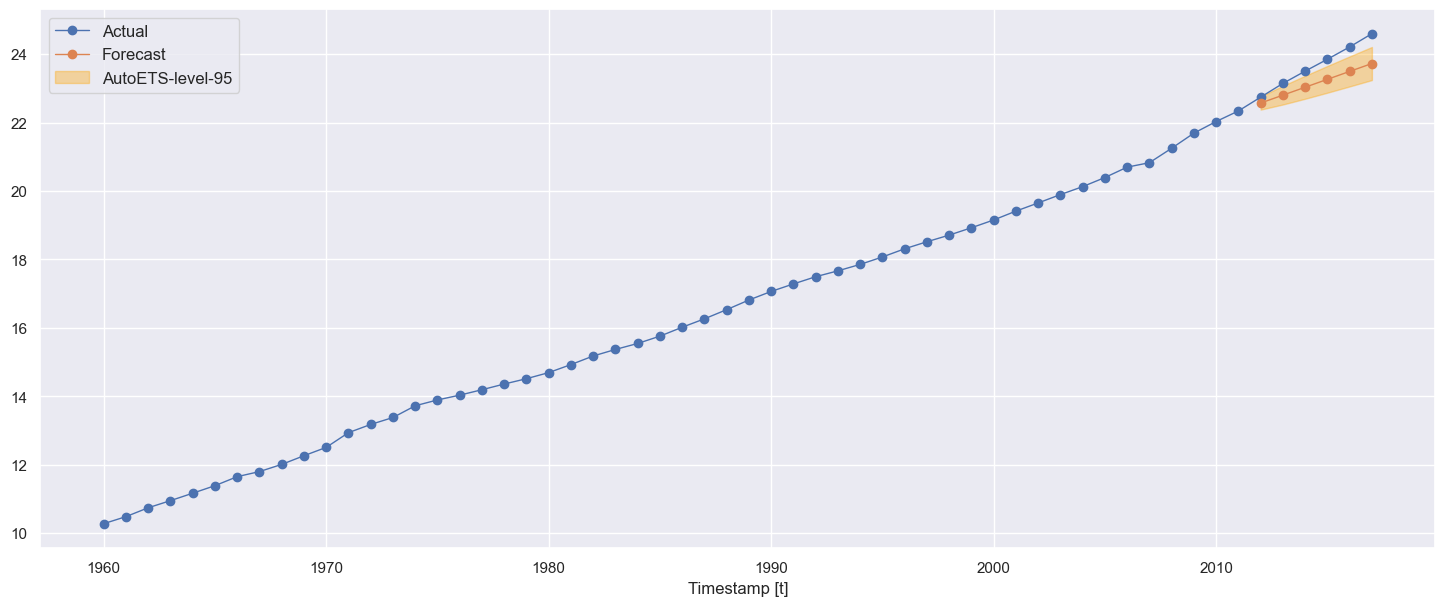

In [128]:
plot_actual_and_forecast(model=autoets, df=df, ds_start=test_df.ds.values[0], freq='ys', 
prediction_horizon=len(test_df))

In [64]:
from utils import model_evaluation

In [126]:
model_evaluation(test_df['y'], forecast['hat'], 'AutoETS')

Model Evaluation: AutoETS
MSE is : 0.3310020488398416
MAE is : 0.5266988989781787
RMSE is : 0.5753277751333075
MAPE is : 2.200336904313833
R2 is : 0.15502660123458822
corr is : 0.9997548670306924



### Automatic Forecasting using AutoARIMA
We test the same forecast using AutoARIMA from the `statsforecast` library.

In [72]:
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [129]:
season_length = 1 # Monthly data
horizon = len(test_df) # Number of predictions

models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(df=train_df, models=models, freq='YS', n_jobs=-1)
sf.fit()

StatsForecast(models=[AutoARIMA])

In [130]:
y_hat_dict = sf.predict(h=6)


In [131]:
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(2,1,0)                   '

In [82]:
model_evaluation(test_df['y'], y_hat_dict['AutoARIMA'], 'AutoARIMA')

Model Evaluation: AutoARIMA
MSE is : 0.09208741337685099
MAE is : 0.2774860915118662
RMSE is : 0.3034590802346356
MAPE is : 1.1591901743588648
R2 is : 0.764921652487405
corr is : 0.9997374028550093



In [108]:
forecasts_df = sf.predict(h=len(test_df), level=[80, 90, 95])

In [111]:
df_plot=df.merge(forecasts_df, how='left', on=['unique_id', 'ds']).set_index('ds')

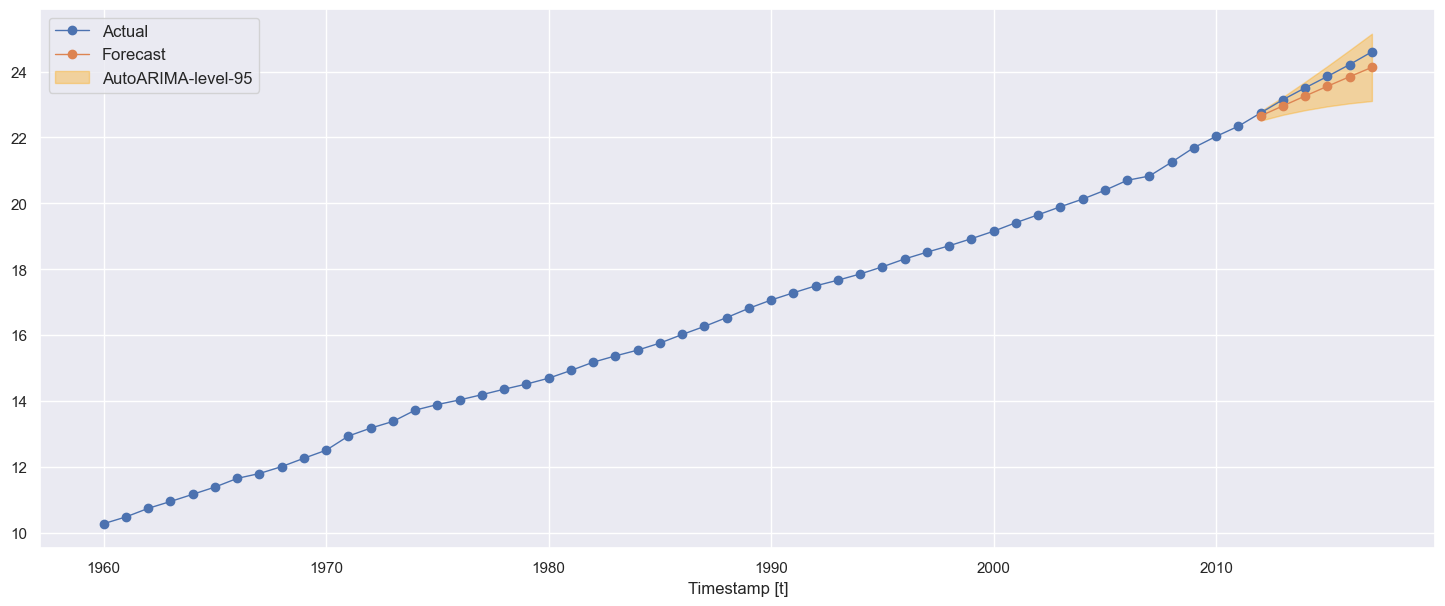

In [115]:

fig, ax = plt.subplots()
plt.plot_date(df_plot.index, df_plot["y"],label="Actual", linestyle="-")
plt.plot_date(df_plot.index, df_plot["AutoARIMA"],label="Forecast", linestyle="-")
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.35,
                color='orange',
                label='AutoARIMA-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
plt.legend(fontsize=12)
ax.grid(True)

From both the evaluation metrics and the graph we can see that ARIMA performs much better in this instance than ETS.